##### Sources for certain modules used in this notebook
-  https://devmount.github.io/GermanWordEmbeddings/
-  http://brandonrose.org/clustering

In [5]:
# Keeping all the imports in one place
# -*- coding: utf-8 -*-
import numpy as np
import base64
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
get_ipython().magic(u'matplotlib inline')
from gensim import corpora, models, similarities
import random
from collections import Counter
from __future__ import division
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
#some ipython magic to show the matplotlib plots inline
%matplotlib inline
import gensim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import tensorflow as tf
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector
from tqdm import tqdm
from gensim.models import KeyedVectors
from time import time
# ENABLE "logging" only when required for inspection and analysis. WMD dist_wmd produces a ton of logs which makes notebook heavy. 
# import logging
# logging.root.handlers = []  # Jupyter messes up logging so needs a reset
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

print "All the imports worked nicely."

All the imports worked nicely.


In [2]:
# loading pre-trained Deutsche word embeddings from different sources.
# SOURCES:
# Model01 Fb fasttext : pre-trained word vectors, trained on Wikipedia using fastText. These vectors in dimension 300 were obtained using the skip-gram model described in Bojanowski et al. (2016) with default parameters.
# https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md
%time model01 = gensim.models.KeyedVectors.load_word2vec_format("wiki.de.vec", binary=False)

# Model: https://devmount.github.io/GermanWordEmbeddings/
%time model = gensim.models.KeyedVectors.load_word2vec_format("german.model", binary=True)

# Model02 : GER64 embeddings https://github.com/glample/tagger
%time model02 = gensim.models.KeyedVectors.load_word2vec_format("GER64", binary=False)

CPU times: user 8min 59s, sys: 12 s, total: 9min 11s
Wall time: 9min 11s
CPU times: user 8.17 s, sys: 860 ms, total: 9.03 s
Wall time: 9.04 s
CPU times: user 2min 1s, sys: 3.5 s, total: 2min 5s
Wall time: 2min 5s


In [7]:
# ------------------EVALUATING different word embeddings ------------------------------------------------------------------
# Checking the vocabulary size for different embeddings
print "Size of vocabulary in model01 is %d" % len(model01.vocab)
print "Size of vocabulary in model02 is %d" % len(model02.vocab)
print "Size of vocabulary in model is %d" % len(model.vocab)

model_wordList = model.index2word
print type(model_wordList), len(model_wordList)
print "First 50 words in Model vocabulary are: ",  ', '.join(model_wordList[:50])
# model.vocab gives you a dictionary sort of embedding_index_de
# print type(word_vectors.vocab)
# fasttext_wordList = word_vectors.index2word
fasttext_wordList = model01.index2word
print type(fasttext_wordList), len(fasttext_wordList)
print "First 50 words in model01 vocabulary are: ",  ', '.join(fasttext_wordList[:50])

ger64_wordList = model02.index2word
print type(ger64_wordList), len(ger64_wordList)
print "First 50 words in model02 vocabulary are: ",  ', '.join(ger64_wordList[:50])

Size of vocabulary in model01 is 2275233
Size of vocabulary in model02 is 2001952
Size of vocabulary in model is 608130
<type 'list'> 608130
First 50 words in Model vocabulary are:  Die, fuer, wurde, Der, dass, Das, ueber, In, Im, wurden, Er, Sie, Jahr, mehr, zwei, Es, Nach, sowie, ab, Jahren, Jahre, sei, Am, beim, drei, seit, koennen, schon, Euro, Stadt, Mit, ersten, Ein, Auch, gibt, etwa, bereits, jedoch, Zeit, immer, Uhr, Als, Bei, 1, Ende, heute, Fuer, sagte, Von, konnte
<type 'list'> 2275233
First 50 words in model01 vocabulary are:  ., ,, </s>, -, der, ), die, (, und, in, von, ', den, im, das, des, mit, ist, er, zu, für, auf, ein, als, dem, eine, wurde, –, auch, sich, nicht, an, es, nach, war, bei, aus, rd, am, sie, cest, bis, ", ich, einer, zum, werden, sind, oder, wird
<type 'list'> 2001952
First 50 words in model02 vocabulary are:  </s>, ., ,, der, die, und, in, '', den, ``, :, mit, das, von, zu, -, im, auf, sich, ist, für, Die, dem, ein, nicht, -RRB-, -LRB-, des, es, eine, au

In [8]:
# Simple function to visually show and compare different words in the embedding vector space
# Function to visualize 2D vectors using PCA/Tsne
# function draw_words
# ... reduces dimensionality of vectors of given words either with PCA or with t-SNE and draws the words into a diagram
# @param word2vec model     to visualize vectors from
# @param list     words     list of word strings to visualize
# @param bool     pca       use PCA (True) or t-SNE (False) to reduce dimensionality 
# @param bool     alternate use different color and label align for every second word
# @param bool     arrows    use arrows to connect related words (items that are next to each other in list)
# @param float    x1        x axis range (from)
# @param float    x2        x axis range (to)
# @param float    y1        y axis range (from)
# @param float    y2        y axis range (to)
# @param string   title     for diagram
def draw_words(model, words, pca=False, alternate=True, arrows=True, x1=3, x2=3, y1=3, y2=3, title=''):
    # get vectors for given words from model
    try:
        vectors = [model[word] for word in words]
    except KeyError, e:
        print "raised key error now looking for lower case word in the vocabulary"
        vectors = [model[word.lower()] for word in words]
    if pca:
        pca = PCA(n_components=2, whiten=True)
        vectors2d = pca.fit(vectors).transform(vectors)
    else:
        tsne = TSNE(n_components=2, random_state=0)
        vectors2d = tsne.fit_transform(vectors)

    # draw image
    plt.figure(figsize=(6,6))
    if pca:
        plt.axis([x1, x2, y1, y2])

    first = True # color alternation to divide given groups
    for point, word in zip(vectors2d , words):
        # plot points
        plt.scatter(point[0], point[1], c='r' if first else 'g')
        # plot word annotations
        plt.annotate(
            word, 
            xy = (point[0], point[1]),
            xytext = (-7, -6) if first else (7, -6),
            textcoords = 'offset points',
            ha = 'right' if first else 'left',
            va = 'bottom',
            size = "x-large"
        )
        first = not first if alternate else first
    # draw arrows
    if arrows:
        for i in xrange(0, len(words)-1, 2):
            a = vectors2d[i][0] + 0.04
            b = vectors2d[i][1]
            c = vectors2d[i+1][0] - 0.04
            d = vectors2d[i+1][1]
            plt.arrow(a, b, c-a, d-b,
                shape='full',
                lw=0.1,
                edgecolor='#bbbbbb',
                facecolor='#bbbbbb',
                length_includes_head=True,
                head_width=0.08,
                width=0.01
            )
    # draw diagram title
    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

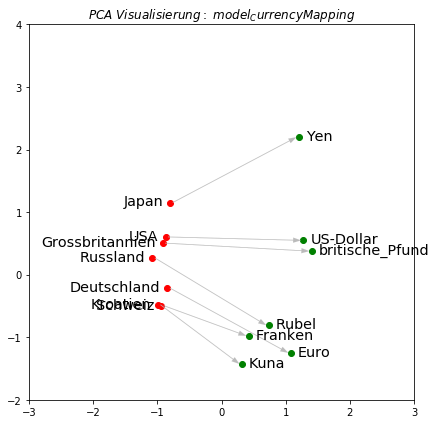

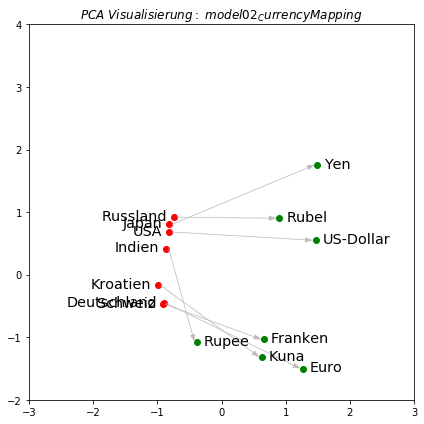

raised key error now looking for lower case word in the vocabulary


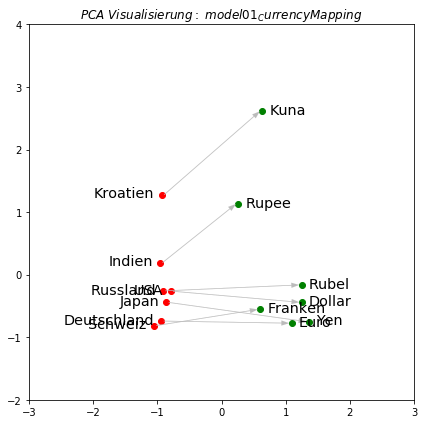

raised key error now looking for lower case word in the vocabulary


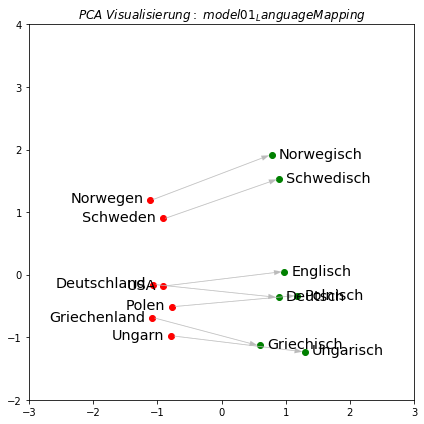

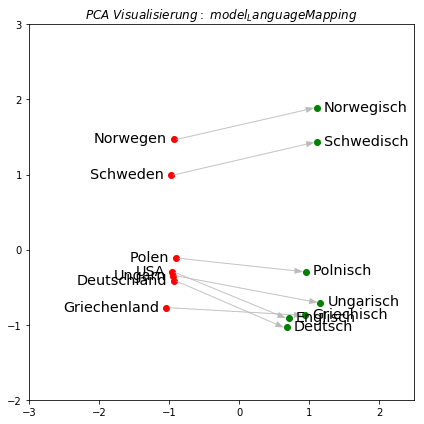

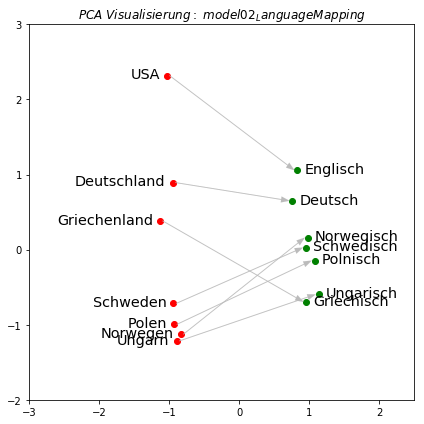

raised key error now looking for lower case word in the vocabulary


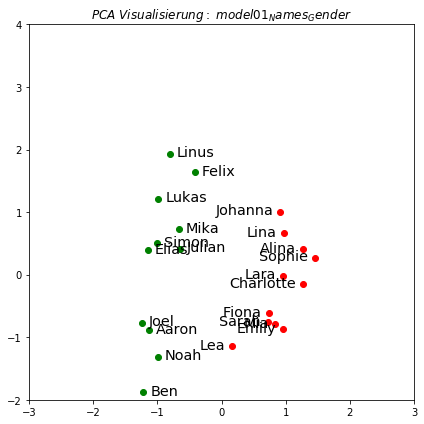

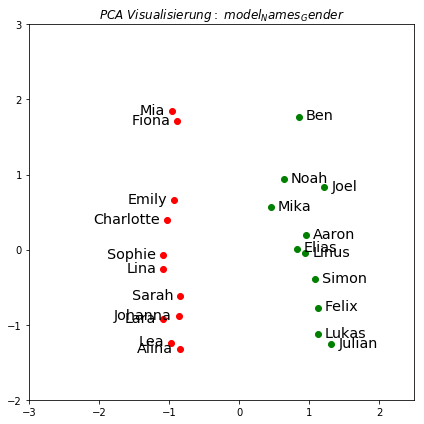

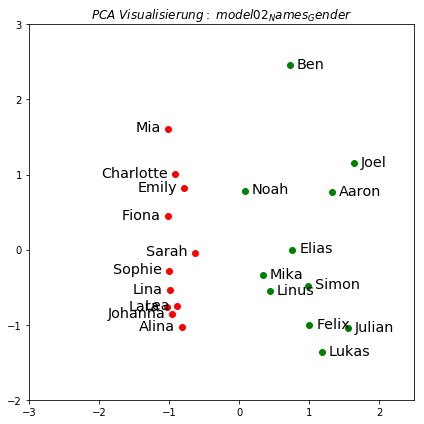

In [9]:
# plot currencies
words = ["Schweiz","Franken","Deutschland","Euro","Grossbritannien","britische_Pfund","Japan","Yen","Russland","Rubel","USA","US-Dollar","Kroatien","Kuna"]
draw_words(model, words, True, True, True, -3, 3, -2, 4, r'$PCA\ Visualisierung:\ model_CurrencyMapping$')

words = ["Schweiz","Franken","Deutschland","Euro","Japan","Yen","Russland","Rubel","USA","US-Dollar","Kroatien","Kuna","Indien", "Rupee"]
draw_words(model02, words, True, True, True, -3, 3, -2, 4, r'$PCA\ Visualisierung:\ model02_CurrencyMapping$')

words = ["Schweiz","Franken","Deutschland","Euro","Japan","Yen","Russland","Rubel","USA","Dollar","Kroatien","Kuna","Indien", "Rupee"]
draw_words(model01, words, True, True, True, -3, 3, -2, 4, r'$PCA\ Visualisierung:\ model01_CurrencyMapping$')

words = ["Deutschland","Deutsch","USA","Englisch","Griechenland","Griechisch","Norwegen","Norwegisch","Schweden","Schwedisch","Polen","Polnisch","Ungarn","Ungarisch"]

draw_words(model01, words, True, True, True, -3, 3, -2, 4, r'$PCA\ Visualisierung:\ model01_LanguageMapping$')
draw_words(model, words, True, True, True, -3, 2.5, -2, 3, r'$PCA\ Visualisierung:\ model_LanguageMapping$')
draw_words(model02, words, True, True, True, -3, 2.5, -2, 3, r'$PCA\ Visualisierung:\ model02_LanguageMapping$')

# showing the underlying understanding of word embedding for different gender names   
words = ["Alina","Aaron","Charlotte","Ben","Emily","Elias","Fiona","Felix","Johanna","Joel","Lara","Julian","Lea","Linus","Lina","Lukas","Mia","Mika","Sarah","Noah","Sophie","Simon"]
draw_words(model01, words, True, True, False, -3, 3, -2, 4, r'$PCA\ Visualisierung:\ model01_Names_Gender$')
draw_words(model, words, True, True, False, -3, 2.5, -2, 3, r'$PCA\ Visualisierung:\ model_Names_Gender$')
draw_words(model02, words, True, True, False, -3, 2.5, -2, 3, r'$PCA\ Visualisierung:\ model02_Names_Gender$')

print

In [7]:
# some more examples to show and compare the word embeddings quality and data
print "Results for vector arithematic = Vector[frau] + Vector[koenig] - Vector[mann]"
print "\n model01 resuls \n %s" % model01.most_similar_cosmul(positive=['frau', 'koenig'], negative=['mann'])
# Note: how model02 does not gives the expected results, but still captures other generalized concepts
print "\n model02 resuls \n %s" % model02.most_similar_cosmul(positive=['frau', 'Koenig'], negative=['mann'])
print "\n model resuls \n %s" % model.most_similar_cosmul(positive=['frau', 'Koenig'], negative=['mann'])

print 
# Another example 
print "Results for vector arithematic = Vector[Obama] + Vector[Russland] - Vector[USA]"
print "\n model resuls \n %s" % model.most_similar_cosmul(positive=['Obama', 'Russland'], negative=['USA'])
print "\n model01 resuls \n %s" % model01.most_similar_cosmul(positive=['obama', 'russland'], negative=['usa'])
print "\n model02 resuls \n %s" % model02.most_similar_cosmul(positive=['Obama', 'Russland'], negative=['USA'])

Results for vector arithematic = Vector[frau] + Vector[koenig] - Vector[mann]

 model01 resuls 
 [(u'koenige', 0.9254183769226074), (u'koenigin', 0.9117096066474915), (u'koenigi', 0.8989173173904419), (u'bkoenig', 0.8936635851860046), (u'erlkoenig', 0.8904488682746887), (u'koenigs', 0.8678578734397888), (u'koeniger', 0.8672288060188293), (u'koenigl', 0.8639868497848511), (u'koenigsfeld', 0.8413063287734985), (u'heussner', 0.8398494720458984)]

 model02 resuls 
 [(u'Cewe', 0.9357702732086182), (u'Thonet', 0.9357085227966309), (u'Villeroy', 0.9339916110038757), (u'Krobath', 0.9337064623832703), (u'Bosch', 0.9327762722969055), (u'Dethleffs', 0.9324429631233215), (u'Schoeller', 0.9311891794204712), (u'Schelhammer', 0.9305253624916077), (u'Casualwear', 0.9298563003540039), (u'Wella', 0.929678738117218)]

 model resuls 
 [(u'Prinzen', 0.9462631344795227), (u'Prinzessin', 0.9387489557266235), (u'Koenigin', 0.9133153557777405), (u'Prinz', 0.8993944525718689), (u'Koenigin_Niederlande', 0.895025

In [32]:
print "Results for vector arithematic = Vector[Kerze] + Vector[Feuerzeug]"
print "\n model resuls \n %s" % model.most_similar_cosmul(positive=['Kerze', 'Feuerzeug'])
print "\n model01 resuls \n %s" % model01.most_similar_cosmul(positive=['kerze', 'feuerzeug'])
print "\n model02 resuls \n %s" % model02.most_similar_cosmul(positive=['Kerze', 'Feuerzeug'])

Results for vector arithematic = Vector[Kerze] + Vector[Feuerzeug]

 model resuls 
 [(u'brennende_Kerze', 0.7145117521286011), (u'Herdplatte', 0.710566520690918), (u'brennende_Zigarette', 0.6972489356994629), (u'Teelicht', 0.6950814127922058), (u'Grablicht', 0.687491774559021), (u'eingeschalteten_Herd', 0.6849476099014282), (u'Zigarettenkippe', 0.6791795492172241), (u'Benzinkanister', 0.6780713796615601), (u'Fussmatte', 0.6776428818702698), (u'achtlos_weggeworfene', 0.6759508848190308)]

 model01 resuls 
 [(u'benzinfeuerzeug', 0.742671012878418), (u'feuerzeugflamme', 0.7228692770004272), (u'feuerzeugs', 0.7227802872657776), (u'feuerzeuges', 0.7193080186843872), (u'gasfeuerzeug', 0.709706723690033), (u'tischfeuerzeug', 0.7011693120002747), (u'kerzen', 0.6958333849906921), (u'feuerzeuggas', 0.6925532817840576), (u'feuerzeugen', 0.687744140625), (u'benzinfeuerzeuge', 0.6857927441596985)]

 model02 resuls 
 [(u'Wunderkerze', 0.9350067973136902), (u'Teelicht', 0.933605968952179), (u'Streich

In [6]:
# Setting up word embeddings to be visualized in Tensor Board - 
# load model
# create a list of vectors
embedding = np.empty((len(model02.vocab), 64), dtype=np.float32)
for i, word in enumerate(model02.vocab):
    embedding[i] = model02[word]

# setup a TensorFlow session
tf.reset_default_graph()
sess = tf.InteractiveSession()
X = tf.Variable([0.0], name='embedding')
place = tf.placeholder(tf.float32, shape=embedding.shape)
set_x = tf.assign(X, place, validate_shape=False)
sess.run(tf.global_variables_initializer())
sess.run(set_x, feed_dict={place: embedding})

# write labels, creating a meta file -
with open('/home/D072852/log/metadata_de_model02.tsv', 'w') as f:
    for key in model02.vocab.iteritems() :
        f.write(key[0].encode('utf-8') + '\n')

# create a TensorFlow summary writer
summary_writer = tf.summary.FileWriter('/home/D072852/log', sess.graph)
config = projector.ProjectorConfig()
embedding_conf = config.embeddings.add()
embedding_conf.tensor_name = 'embedding:0'
embedding_conf.metadata_path = os.path.join('/home/D072852/log', 'metadata_de_model02.tsv')
projector.visualize_embeddings(summary_writer, config)

# save the model
saver = tf.train.Saver()
saver.save(sess, os.path.join('/home/D072852/log', "model_de_model02.ckpt"))

'/home/D072852/log/model_de_model02.ckpt'

In [10]:
# --------------------------------------------------------------------------------------------
# ----Beginning with data processing and Thalia Bookstore data specific implementations-------
# ---------------------------------------------------------------------------------------------
# function taking data frame as input preprocess and return another data frame
def dataPreprocess(train) :
    train = train.iloc[:, :-1]
    train.drop(train.columns[0], axis=1, inplace=True)
    print("Number of rows, columns in train dataset : ",train.shape)
    print train.columns
    print train.dtypes
    train.head(2)
    print "Before removing the duplicates\n", train['ADDITIONALTEXT'].describe()
    # dropping the rows with duplicate values in Additional text field -
    train.drop_duplicates(subset='ADDITIONALTEXT', keep="first", inplace=True)
    print "AFTER removing the duplicates\n", train['ADDITIONALTEXT'].describe()
    train.head(2)
    return train

# trying some plotting of data wrt THEMES
def dataVisualise(train) :
    import matplotlib as mpl
    # Just making the plots look better
    mpl.style.use('ggplot')
    mpl.rcParams['figure.figsize'] = (8,6)
    mpl.rcParams['font.size'] = 16
    print "CHECKING for themes now\n", train['THEME'].describe()
    # trying to filter out the long tail and keep only themes with count more than 3
    counts = train['THEME'].value_counts()
    counts1 =  counts[counts >= 2]
    print "DISTRIBUTION of THEMES:"
    print counts1
    plot_data_theme = train[train['THEME'].isin(counts[counts >= 3].index)]
    plot_data_theme['THEME'].value_counts().plot.bar(y='THEME', figsize=(15,10))

    print "CHECKING for keywords now\n", train['SCHLAGWORT'].describe()
    counts = train['SCHLAGWORT'].value_counts()
    counts2 = counts[counts >= 2]
    print "DISTRIBUTION of Schlagworts:"
    print counts2
#     plot_data_schlagwort = train[train['SCHLAGWORT'].isin(counts[counts >= 4].index)]
#     plot_data_schlagwort['SCHLAGWORT'].value_counts().plot.bar(figsize=(25,10))

    # We can see there are only two categories - Subject and Main Subject.
    print "CHECKING for categories now\n", train['CATEGORY'].describe()

# Exploring the data distribution in our train and test set
# trying to filter out the long tail and keep only themes/other attributes with count more 
# than "threshold" value provided
def data_explore(dataFrame, attribute, threshold):
    counts = dataFrame[attribute].value_counts()
    counts1 =  counts[counts >= 1]
    print "--------DISTRIBUTION of %s in data is:---------" %(attribute)
    print counts1
    plot_data_theme = dataFrame[dataFrame[attribute].isin(counts[counts >= threshold].index)]
    plot_data_theme[attribute].value_counts().plot.bar(y=attribute, figsize=(15,15))

# function to prune the data based on the threshold occurence of number of documents in a specific
# Theme/other attribute    
def data_prune(dataFrame, attribute, threshold):
    counts = dataFrame[attribute].value_counts()
    print "-------DISTRIBUTION of %s in data before Pruning is:--------" %(attribute)
    counts1 =  counts[counts >= 1]
    print counts1
    print "--------DISTRIBUTION of %s in data AFTER Pruning is:---------" %(attribute)
    counts2 = counts[counts >= threshold]
    print counts2
    return dataFrame[dataFrame[attribute].isin(counts[counts >= threshold].index)]

CPU times: user 11.2 s, sys: 1.54 s, total: 12.8 s
Wall time: 13.1 s
('Number of rows, columns in train dataset : ', (1000000, 10))
Index([u'MATNR', u'ARTIDENTNO', u'ADDITIONALTEXT', u'RATING', u'RATINGTITEL',
       u'RATINGTEXT', u'RATEDAT', u'SCHLAGWORT', u'CATEGORY', u'THEME'],
      dtype='object')
MATNR             object
ARTIDENTNO         int64
ADDITIONALTEXT    object
RATING             int64
RATINGTITEL       object
RATINGTEXT        object
RATEDAT           object
SCHLAGWORT        object
CATEGORY          object
THEME             object
dtype: object
Before removing the duplicates
count                                               1000000
unique                                                 6777
top       <br>            <p>                <strong>»Ei...
freq                                                  30420
Name: ADDITIONALTEXT, dtype: object
AFTER removing the duplicates
count                                                  6777
unique                            

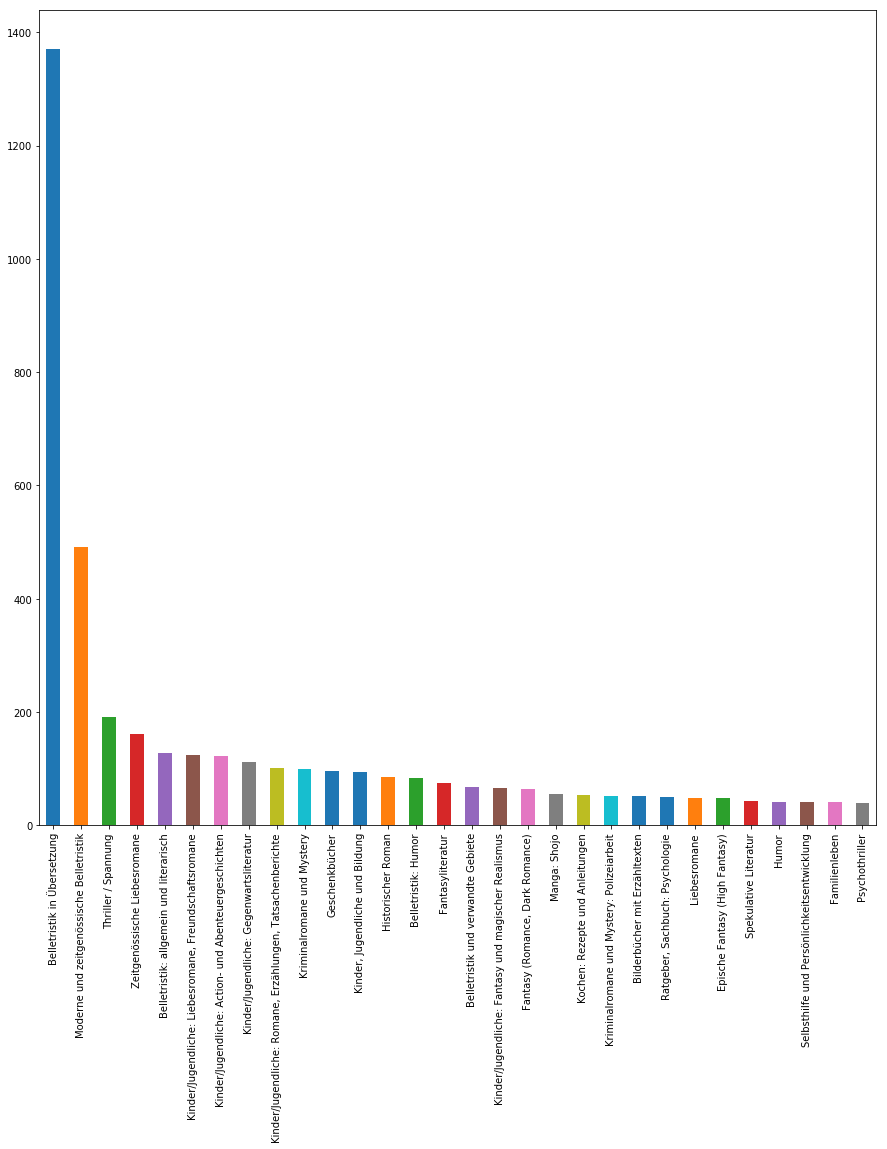

In [13]:
# taking data input and processing, reading first nrows(million here) ONLY
%time train = pd.read_csv("/home/D072852/Thalia_data/thalia.csv", sep='|', nrows=1000000)
train = dataPreprocess(train)
# trying some plotting of data wrt THEMES for first million records
data_explore(train, "THEME", 40)
print "----------------------------------------------------------------"

In [14]:
# fist look at the data with all columns and NO duplicate entries in terms of "Additional Text"
train.head(10)

,MATNR,ARTIDENTNO,ADDITIONALTEXT,RATING,RATINGTITEL,RATINGTEXT,RATEDAT,SCHLAGWORT,CATEGORY,THEME
0,A1026834633,33669870,PECUNIA<br>Der Versicherungs-Ratgeber von Dirk...,50,sehr gutes buch,Dieses Werk hat mir sehr geholfen bei meiner E...,08.12.12 15:57,Kartonierter Einband (Kt),mainsubject,Selbsthilfe und Persönlichkeitsentwicklung
20,A1022787682,32054271,Hündchen Bello möchte krähen können wie Hahn K...,50,Kindheitserinnerungen...,Was habe ich die Geschichten ums Entlein Schna...,06.07.12 11:42,Audio CD (CD/SACD) (CD),mainsubject,"Kinder/Jugendliche: Romane, Erzählungen, Tatsa..."
27,A1030481443,35358198,<p>Hana verliebt sich in einen mysteriösen jun...,50,Wolf oder Mensch?,Ame & Yuki  Die Wolfskinder ist eine wunder...,16.12.14 13:01,Kartonierter Einband (Kt),mainsubject,Manga: Shojo
35,A1029053070,34461069,"Vampir, Werwolf und Dämonin &amp;#8211; mit di...",40,Zufriedenstellendes Ende der Trilogie,Nach den Ereignissen in Göttin der Finsternis...,25.11.16 15:09,Kartonierter Einband (Kt),subject,"Fantasy (Romance, Dark Romance)"
71,A1038964023,44807019,"Was tun, wenn ein Baum plötzlich Bonbonfrüchte...",50,Wenn Du auf einen Bonbonbaum triffst...,Kurzbeschreibung\nWas würde passieren wenn ihr...,22.05.16 09:00,Fester Einband,subject,Kinder/Jugendliche: Lustige Romane
91,A1020288803,30809711,<p>Brauchen Sie eine kleine Erfrischung? Haben...,50,Eiscreme,Leckeres Eis und Milchshakes selber machen kli...,06.05.13 18:38,Fester Einband,subject,Kochen: Desserts
316,A1037783195,43862745,<p>Eine Methodengeschichte psychologischer For...,50,Methodengeschichte psychologischer Forschung u...,"Von Sternen, Fröschen und Monaden  wie man de...",08.09.17 13:48,Kartonierter Einband (Kt),mainsubject,"Ratgeber, Sachbuch: Psychologie"
332,A1014446928,24574132,Winter 1947 in Hohenschöpping im Havelland. Dr...,50,Jora und Knopotschka,Hohenschöpping im Havelland im Winter 1947. Ei...,19.10.10 17:47,Fester Einband,mainsubject,Geschichte
344,A1010991253,19910830,Das Zimmer Rumpelkammer ist einer der Wohnräum...,50,"Bravo, ein im wahrsten Sinne lebendiges Kinder...",Ich habe lange nach dem richtigen Buch für mei...,27.03.10 22:28,Kartonierter Einband (Kt),mainsubject,"Kinder/Jugendliche: Romane, Erzählungen, Tatsa..."
345,A1034729376,40940039,Mit seiner landschaftlichen Schönheit und sage...,50,Michael Lange - Fluss,"Michael Lange - Fluss\n\nDer Rhein, deutscher ...",16.06.15 13:49,Fester Einband,mainsubject,Fotografie


----------------------------------------------------------------
CHECKING for themes now
count                                 134
unique                                  3
top       Kochen: Rezepte und Anleitungen
freq                                   53
Name: THEME, dtype: object
DISTRIBUTION of THEMES:
Kochen: Rezepte und Anleitungen    53
Humor                              41
Psychothriller                     40
Name: THEME, dtype: int64
CHECKING for keywords now
count                           134
unique                           66
top       Kartonierter Einband (Kt)
freq                             20
Name: SCHLAGWORT, dtype: object
DISTRIBUTION of Schlagworts:
Kartonierter Einband (Kt)                          20
Fester Einband                                     15
Thriller                                           10
Roman                                               6
Audio CD (CD/SACD) (CD)                             6
Psychothriller                                     

,MATNR,ARTIDENTNO,ADDITIONALTEXT,RATING,RATINGTITEL,RATINGTEXT,RATEDAT,SCHLAGWORT,CATEGORY,THEME
876315,A1032755556,37867479,Ein Platz für Ihre Lieblingsrezepte<br></br><b...,50,Tolles Sammelbuch zum Einkleben,"Das Buch ist sehr geeignet, wenn man viele kle...",21.07.16 21:42,"Album, vorbedruckt geb",subject,Kochen: Rezepte und Anleitungen
878261,A1039482519,45243640,The Court &amp;#8211; das waren die Coolen. Di...,50,So muss ein Thriller sein,Lana trifft zufällig einen alten Bekannten wie...,01.05.17 11:17,Thriller,subject,Psychothriller
882296,A1038063227,44165619,Schluss mit Zusatzstoffen!<br></br><br /></br>...,50,Ideal für Anfänger und Fortgeschrittenen,Bin total begeistert von diesem Buch. Zahlreic...,08.09.16 17:33,Kartonierter Einband (Kt),subject,Kochen: Rezepte und Anleitungen
883047,A1000260076,2996845,Dieses Grundlagenwerk liefert in Wort und Bild...,50,Zu empfehlen!,"Ich bin begeistert, ich hatte vorher noch nie ...",10.04.13 21:54,Rezepte,subject,Kochen: Rezepte und Anleitungen
884329,A1034937261,40981441,La dolce vita<br></br><br /></br>Italien ist u...,50,Italien für Zuhause!,"Hält man das Buch erst einmal in Händen, falle...",25.08.15 19:40,"Italien : Kochbücher, Wein",subject,Kochen: Rezepte und Anleitungen
891787,A1043362981,47092932,Der neue Spannungsroman von Paula Hawkins nach...,50,Beckford ist kein Ort für Selbstmörder. Beckf...,Und wieder ist der Thriller von Paula Hawkins ...,28.05.17 14:18,Kartonierter Einband (Kt),mainsubject,Psychothriller
892590,A1030317773,35146784,Traue niemandem &amp;#8211; nicht einmal dir s...,50,Wenn man sich selbst nicht trauen kann,Seit dem Tod ihres kleinen Bruders Kai wird Do...,04.06.14 12:44,Taschenbuch (kartoniert),subject,Psychothriller
894659,A1037739737,43822165,"Eat Clean, Feel Great! <br></br><br /></br>Unt...",30,Der Augenmerk ist zu sehr auf teure und exklus...,Meine Meinung zum Kochbuch: \nClean Eating Nat...,21.08.16 09:48,Gesunde Ernährung,subject,Kochen: Rezepte und Anleitungen
895262,A1045125439,62295012,Ihr Name war Zena. Tom macht kein Geheimnis au...,30,Mir fehlt das gewisse Etwas eines Thrillers,Eigentlich könnte Carmen kaum glücklicher sein...,01.10.17 19:48,Psychothriller,mainsubject,Psychothriller
896902,A1042992549,47877784,Die kleine Tochter der alleinerziehenden Lehre...,50,Lässt tief in menschliche Abgründe blicken,Geständnisse erzählt die Geschichte vom Mord...,16.06.17 07:47,Roman,mainsubject,Psychothriller


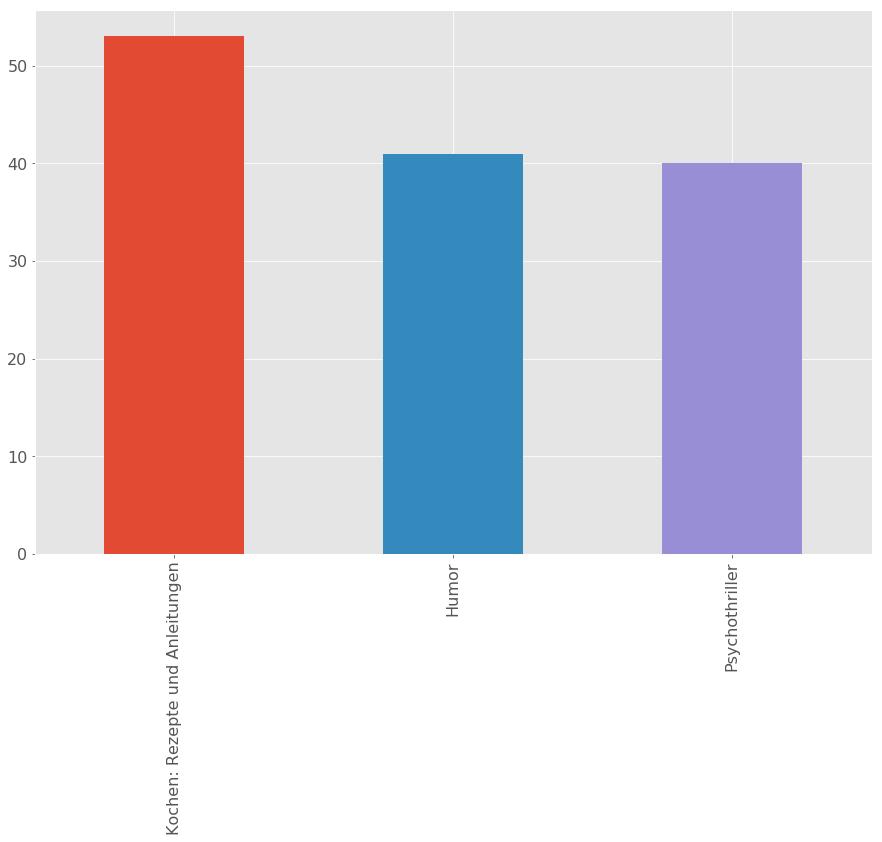

In [15]:
# Now pruning the data to keep only top 10 THEMES for further clustering evaluation
# train = data_prune(train, 'THEME', 120)
print "----------------------------------------------------------------"
# keeping only values relating to specific "un-related" THEMES
train = train.loc[train['THEME'].isin(['Kochen: Rezepte und Anleitungen','Humor','Psychothriller'])]
# train = train.loc[train['THEME'].isin(['Selbsthilfe und Persönlichkeitsentwicklung','Bilderbücher mit Erzähltexten','Kochen: Rezepte und Anleitungen'])]

# trying some plotting of data wrt THEMES
dataVisualise(train)

train_text = train['ADDITIONALTEXT'].tolist()
train_id = train['MATNR'].tolist()
train_theme = train['THEME'].tolist()
train_schlagwort = train['SCHLAGWORT'].tolist()

# some sanity checks for data
print len(train_id)
print len(train_text)

total_len = 0
# calculating the average text lenght in training corpus
for s in train_text:
    total_len = total_len + len(s.split())
average_text_len = total_len/len(train_text)

print "Average length of the documents in training corpus is", average_text_len

train.head()
train.tail(10)

In [18]:
# Actual data preprocessing starts from here - 

# load nltk's SnowballStemmer as variabled 'stemmer'
# NOTE - this stemmer works by brute force chunking of fthe "en"/"es" from word endings plus it removes 1. casing information 2. Umlaut and special character information. On the whole lot of information loss. Advice to use SPACY lemmatizer.
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("german")

# Lemmatizer does NOT work for Deutsche language 
# from nltk.stem import WordNetLemmatizer
# wnl = WordNetLemmatizer()

# generating list of stop_words with title case to be removed from text as well
stop_words = stopwords.words('german')
stop_words_caps = [word.title() for word in stop_words]
stop_words.extend(stop_words_caps)
# extra missing (variations of) stop words that pop up in data
extra_stop_words = ["dass","amp", "Und", "her", "Her", "/br"]
stop_words.extend(extra_stop_words)
# print stop_words, len(stop_words)

# Here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation) 
#     and words whose length is less than 2 characters - removes <br/a> formating from data 
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    return filtered_tokens

def tokenize_and_stopWordsRemoval(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation) and words whose length is less than 2 characters - removes <br/a> formating from data 
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token) > 2 and token not in stop_words :
            filtered_tokens.append(token)
    return filtered_tokens

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag
def strip_proppers_POS(text):
    tagged = pos_tag(text) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

print "BEFORE preprocess text looks like - "
print train_text[2]

#tokenize
%time tokenized_text = [tokenize_only(text.decode('utf-8')) for text in train_text]
%time tokenizedStemmed_text = [tokenize_and_stem(text.decode('utf-8')) for text in train_text]

print "done with tokenisation","After tokenisation text is -"
# print tokenized_text[0]
for word in tokenized_text[2]:
    print word,    
    
#remove stop words
%time texts = [[word for word in text if word not in stop_words] for text in tokenized_text]
print "done with stop word removal","After stop word removal text is -"
for word in texts[2]:
    print word,

BEFORE preprocess text looks like - 
<p>Riege 1928. Ein gemeiner Kinderstreich endet für Clara mit dem Tod. Vier Freundinnen schwören, niemals preiszugeben, was an jenem tragischen Tag im Wald bei den Ramselhöfen tatsächlich geschah.<br>Dreißig Jahre später stößt der englische Journalist Henry Miller auf das Geheimnis um Claras Tod udn kommt bei seinen Recherchen der Wahrheit gefährlich nahe. <br>Claras Todestag naht und unheimliche Dinge geschehen in Riege. Die vier Freundinnen bekommen es mit der Angst zu tun - und das zu Recht.</p>
CPU times: user 255 ms, sys: 4 ms, total: 259 ms
Wall time: 273 ms
CPU times: user 334 ms, sys: 24.6 ms, total: 359 ms
Wall time: 362 ms
done with tokenisation After tokenisation text is -
Riege Ein gemeiner Kinderstreich endet für Clara mit dem Tod Vier Freundinnen schwören niemals preiszugeben was jenem tragischen Tag Wald bei den Ramselhöfen tatsächlich geschah. Dreißig Jahre später stößt der englische Journalist Henry Miller auf das Geheimnis Claras T

In [129]:
# Applying Word Movers Distance and analysing results on the current corpus
# http://proceedings.mlr.press/v37/kusnerb15.pdf

# Initialize WmdSimilarity.
from gensim.similarities import WmdSimilarity
num_best = 10
instance = WmdSimilarity(texts, model02, num_best=10)
start = time()

sims = instance[texts[80]]  # A query is simply a "look-up" in the similarity class.
print 'Cell took %.2f seconds to run.' %(time() - start)

Cell took 7.31 seconds to run.


In [130]:
# Print the query and the retrieved documents, together with their similarities.
print 'Query:'
# making a copy of the preprocessed data frame
work_df = train
print work_df.iloc()[80]['ADDITIONALTEXT']
# sanity check, indexes in the data frame and processed texts should point to same documents 
print " ".join(texts[80])
# print type(sims)
for i in range(10):
    print
    print 'sim = %.4f' % sims[i][1]
    print sims[i][0]
    print "Theme is %s" % work_df.iloc()[sims[i][0]]['THEME']
    print "Schlagworts are %s" % work_df.iloc()[sims[i][0]]['SCHLAGWORT']
    print work_df.iloc()[sims[i][0]]['ADDITIONALTEXT']
#     print (" ").join(texts[sims[i][0]])

Query:
Fesselnd, abgründig, raffiniert<br></br><br /></br>Er beobachtet das Leben wildfremder Frauen. Träumt sich an ihre Seite, in ihren Alltag. Identifiziert sich mit ihnen und will alles von ihnen wissen. Als Beobachter. Auf der Flucht vor seinem eigenen Dasein, das aus Misserfolgen besteht. Nur aus der Ferne liebt er die schöne Gillian Ward. Die beruflich erfolgreiche Frau, glücklich verheiratet, Mutter einer reizenden Tochter, wird von ihm über die Maßen idealisiert. Bis er zu seinem Entsetzen erkennt, dass er auf eine Fassade hereingefallen ist. Denn nichts ist so, wie es scheint. Gleichzeitig schreckt eine Mordserie die Menschen in London auf. Die Opfer: alleinstehende Frauen. Auf eine rachsüchtige, sadistische Weise umgebracht. Die Polizei sucht einen Psychopathen. Einen Mann, der Frauen hasst.<br></br><br /></br><br>
Fesselnd abgründig raffiniert beobachtet Leben wildfremder Frauen Träumt Seite Alltag Identifiziert wissen Beobachter Flucht eigenen Dasein Misserfolgen besteht F

In [32]:
# Applying Word Movers Distance and analysing results on the current corpus
# http://proceedings.mlr.press/v37/kusnerb15.pdf
# wrapping the above process in a generic function to be used later
def kNearestNeighborWMD(textCorpusOriginal, textCorpusProcessed, embeddingModel, query, k):
    # Initialize WmdSimilarity.
    num_best = k
    instance = WmdSimilarity(textCorpusProcessed, embeddingModel, num_best=k)
    start = time()

    sims = instance[query]  # A query is simply a "look-up" in the similarity class.
    print 'Cell took %.2f seconds to run.' %(time() - start)
    # Print the query and the retrieved documents, together with their similarities.
    print 'Query:'
    print " ".join(query)
    for i in range(k):
        print
        print 'sim = %.4f' % sims[i][1]
        print sims[i][0]
#         print "Theme is %s" % work_df.iloc()[sims[i][0]]['THEME']
#         print "Schlagworts are %s" % work_df.iloc()[sims[i][0]]['SCHLAGWORT']
#         print work_df.iloc()[sims[i][0]]['ADDITIONALTEXT']
        print ("").join(textCorpusOriginal[sims[i][0]])

In [25]:
kNearestNeighborWMD(texts, model02, train, texts[80], 10)

Cell took 7.46 seconds to run.
Query:
Fesselnd abgründig raffiniert beobachtet Leben wildfremder Frauen Träumt Seite Alltag Identifiziert wissen Beobachter Flucht eigenen Dasein Misserfolgen besteht Ferne liebt schöne Gillian Ward beruflich erfolgreiche Frau glücklich verheiratet Mutter reizenden Tochter Maßen idealisiert Entsetzen erkennt Fassade hereingefallen scheint Gleichzeitig schreckt Mordserie Menschen London Opfer alleinstehende Frauen rachsüchtige sadistische Weise umgebracht Polizei sucht Psychopathen Mann Frauen hasst.

sim = 1.0000
80
Theme is Psychothriller
Schlagworts are Roman
Fesselnd, abgründig, raffiniert<br></br><br /></br>Er beobachtet das Leben wildfremder Frauen. Träumt sich an ihre Seite, in ihren Alltag. Identifiziert sich mit ihnen und will alles von ihnen wissen. Als Beobachter. Auf der Flucht vor seinem eigenen Dasein, das aus Misserfolgen besteht. Nur aus der Ferne liebt er die schöne Gillian Ward. Die beruflich erfolgreiche Frau, glücklich verheiratet, Mut

In [92]:
# computing pairwise distance matrix for the given corpus using WMD
distance_WMD = np.zeros((len(texts),len(texts)))
%timeit
# distance_WMD = np.zeros((1000,1000))
print len(texts)
print distance_WMD.shape
# calculate distances only between different documents(i!=j) and 
# where the distance is not set yet(zero intialised)
# once calculated dist(i, j), set dist(j, i) to be the same value to save extra computations  
start = time()
for i in range(len(texts)):
    for j in range(len(texts)):
        if distance_WMD[i,j] == 0 and i != j:
            distance_WMD[i,j] = model.wmdistance(texts[i], texts[j])
            distance_WMD[j,i] = distance_WMD[i,j]
print 'Cell took %.2f seconds to run.' %(time() - start)

145
(145, 145)
Cell took 390.21 seconds to run.


In [131]:
from sklearn.externals import joblib
# saving/loading the model data
#since I've already run my model I am loading from the pickle
# joblib.dump(distance_WMD,  'doc145_distance_WMD_model_.pkl')
distance_WMD = joblib.load('doc134_distance_WMD_model01.pkl')

In [132]:
# using spectral clustering to cluster points represented by wmd_distamcep[n*n] matrix
# ToDo - check other available clustering algorithms performace for custom distance matrix
from sklearn.cluster import SpectralClustering
from sklearn import metrics
# Cluster
sc = SpectralClustering(3, affinity='precomputed', n_init=100)
sc.fit(distance_WMD)
# sc.fit(dist)
clusters_wmd = sc.labels_.tolist()

# Observation: Spectral clustering performs poorly on our data points and put them all 
# in one large cluster.

#create data frame that has the result of the cluster numbers and titles
df = pd.DataFrame(dict(cluster_label=clusters_wmd, theme=train_theme)) 
d=df.groupby(['cluster_label', 'theme']).theme.count()
d = d.groupby(level=0).apply(lambda x: x.sort_values(ascending=False))
print "distribution of documents across Theme are %s " % Counter(train_theme[:500])
print "distribution of documents across clusters are %s " % Counter(clusters_wmd)

# Number of documents belonging to a cluster grouped by the Theme 
d.head(100)

distribution of documents across Theme are Counter({'Kochen: Rezepte und Anleitungen': 53, 'Humor': 41, 'Psychothriller': 40}) 
distribution of documents across clusters are Counter({0: 132, 1: 1, 2: 1}) 


cluster_label  cluster_label  theme                          
0              0              Kochen: Rezepte und Anleitungen    51
                              Humor                              41
                              Psychothriller                     40
1              1              Kochen: Rezepte und Anleitungen     1
2              2              Kochen: Rezepte und Anleitungen     1
Name: theme, dtype: int64

In [133]:
# Using Manifold learning - Multidimensional Scaling technique to project higher dimension non linearly
# related data points from our distance_WMD matrix to lower dimension(2D) points as we're 
# plotting points in a two-dimensional plane.
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
from sklearn.manifold import MDS
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
# %time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
%time pos = mds.fit_transform(distance_WMD)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]
# another mds instance to check the performance on non metric MDS
# http://scikit-learn.org/dev/auto_examples/manifold/plot_mds.html
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=1,
                   dissimilarity="precomputed", n_jobs=1)
%time pos = mds.fit(distance_WMD).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12,
                    dissimilarity="precomputed", random_state=1, n_jobs=1,
                    n_init=1)
%time npos = nmds.fit_transform(distance_WMD, init=pos)
xs_nmds, ys_nmds = npos[:, 0], npos[:, 1]

CPU times: user 510 ms, sys: 7.25 ms, total: 517 ms
Wall time: 516 ms
CPU times: user 2.36 s, sys: 3.76 ms, total: 2.36 s
Wall time: 2.36 s
CPU times: user 28.9 ms, sys: 0 ns, total: 28.9 ms
Wall time: 28.7 ms


In [141]:
# Evaluating the performance on PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=1)
%time pos_pca = pca.fit_transform(distance_WMD)
xs_pca, ys_pca = pos_pca[:, 0], pos_pca[:, 1]

# Evaluating the performance on LLE
from sklearn.manifold import LocallyLinearEmbedding
model_lle = LocallyLinearEmbedding(n_neighbors=20, n_components=2, method='modified',
                               eigen_solver='auto', random_state=1)
%time pos_lle = model_lle.fit_transform(distance_WMD)
xs_lle, ys_lle = pos_lle[:, 0], pos_lle[:, 1]

# Evaluating the performance on ISOMAP
from sklearn import manifold

iso = manifold.Isomap(n_neighbors=10, n_components=2)
iso.fit(distance_WMD)
%time pos_isomap = iso.transform(distance_WMD)
xs_iso, ys_iso = pos_isomap[:, 0], pos_isomap[:, 1]
manifold_2Da = iso.transform(distance_WMD)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['x', 'y'])

# Left with 2 dimensions
manifold_2D.head()

# Evaluating performance on Tsne
%time pos_tsne = TSNE(n_components=2, perplexity=40, verbose=2, random_state=1).fit_transform(distance_WMD)
xs_tsne, ys_tsne = pos_tsne[:, 0], pos_tsne[:, 1]

CPU times: user 218 ms, sys: 363 ms, total: 581 ms
Wall time: 35 ms
CPU times: user 632 ms, sys: 1.86 s, total: 2.5 s
Wall time: 91.2 ms
CPU times: user 91 ms, sys: 105 ms, total: 196 ms
Wall time: 8.54 ms
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.000s...
[t-SNE] Computed neighbors for 134 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 0.427865
[t-SNE] Computed conditional probabilities in 0.025s
[t-SNE] Iteration 50: error = 54.6093750, gradient norm = 0.5336224 (50 iterations in 0.128s)
[t-SNE] Iteration 100: error = 55.8625565, gradient norm = 0.4806267 (50 iterations in 0.122s)
[t-SNE] Iteration 150: error = 53.7116623, gradient norm = 0.4802583 (50 iterations in 0.124s)
[t-SNE] Iteration 200: error = 53.5628738, gradient norm = 0.4871493 (50 iterations in 0.123s)
[t-SNE] Iteration 250: error = 54.9987030, gradient norm = 0.5328933 (50 iterations in 0.122s)
[t-SNE] KL divergence after 250 it

In [154]:
# setting up plot by "clustering" x's and y's based on WMD and reduced to 2D data points
#--------------------------------------------------------------------------------------

#set up colors per clusters using a dict
# #800000, #FFFF00, #8B0000, #9932CC, #ADFF2F
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#800000', 6: '#FFFF00', 7: '#8B0000', 8: '#9932CC', 9: '#ADFF2F', 10: '#228B22', 11: '#00FFFF'}

#set up cluster names using a dict
cluster_names = {0: 'Kochen: Rezepte und Anleitungen', 
                 1: 'Psychothriller', 
                 2: 'Humor', 
                 3: 'Bilderbücher mit Erzähltexten', 
                 4: 'Belletristik: allgemein und literarisch',
                 5: 'Selbsthilfe und Persönlichkeitsentwicklung', 
                 6: 'Kinder/Jugendliche: Action- und Abenteuergeschichten', 
                 7: 'Kinder/Jugendliche: Gegenwartsliteratur', 
                 8: 'Kinder/Jugendliche: Romane, Erzählungen, Tatsachenberichte', 
                 9: 'Kriminalromane und Mystery',
                 10: 'Geschenkbücher',
                 11: 'Kinder, Jugendliche und Bildung'}

inv_cluster_names = {v: k for k, v in cluster_names.iteritems()}

#set up cluster names according to cluster label using a dict
cluster_numbers= {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4',
                 5: 'Cluster 5', 
                 6: 'Cluster 6', 
                 7: 'Cluster 7', 
                 8: 'Cluster 8', 
                 9: 'Cluster 9',
                 10: 'Cluster 10',
                 11: 'Cluster 11'}

def plot_data(df, attribute):
    groups = df.groupby(attribute)
    # set up plot
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label

    for name, group in groups:
        print "name of theme = %s, code = %s, color_key = %s" % ((name).decode('utf-8'), inv_cluster_names[name], cluster_colors[inv_cluster_names[name]])
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label=(name).decode('utf-8'), color=cluster_colors[inv_cluster_names[name]], 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')

    ax.legend(numpoints=1)  #show legend with only 1 point

    # add label in x,y position with the document ID as an identifier
#     for i in range(len(df)):
#         if (i == 96) or (i == 103) or (i == 83) or (i == 112) or (i == 116) or (i == 110):  
#             ax.text(df.iloc[i]['x'], df.iloc[i]['y'], i, size=10)      

    plt.show() #show the plot

    #uncomment the below to save the plot if need be
    #plt.savefig('clusters_small_noaxes.png', dpi=200)

--------Plot generated using data from MDS---------
name of theme = Humor, code = 2, color_key = #7570b3
name of theme = Kochen: Rezepte und Anleitungen, code = 0, color_key = #1b9e77
name of theme = Psychothriller, code = 1, color_key = #d95f02


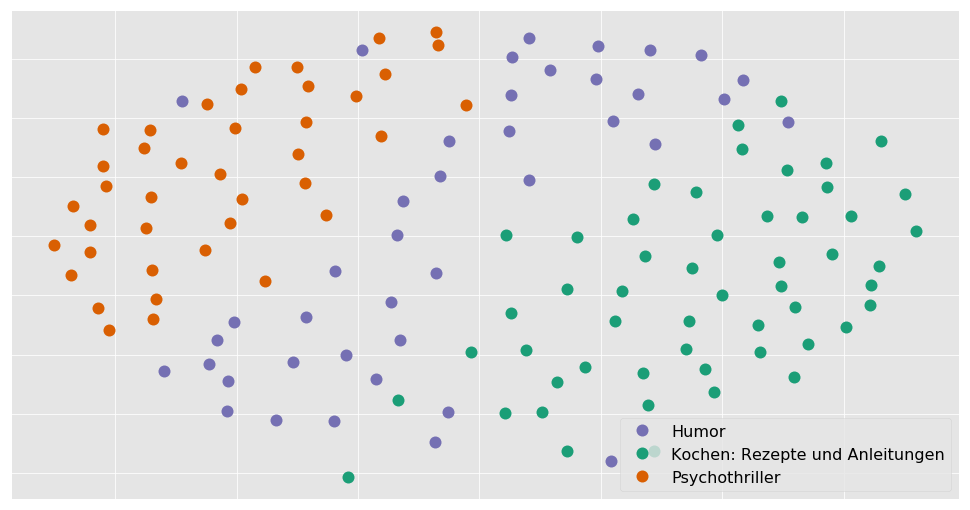

--------Plot generated using data from NMDS---------
name of theme = Humor, code = 2, color_key = #7570b3
name of theme = Kochen: Rezepte und Anleitungen, code = 0, color_key = #1b9e77
name of theme = Psychothriller, code = 1, color_key = #d95f02


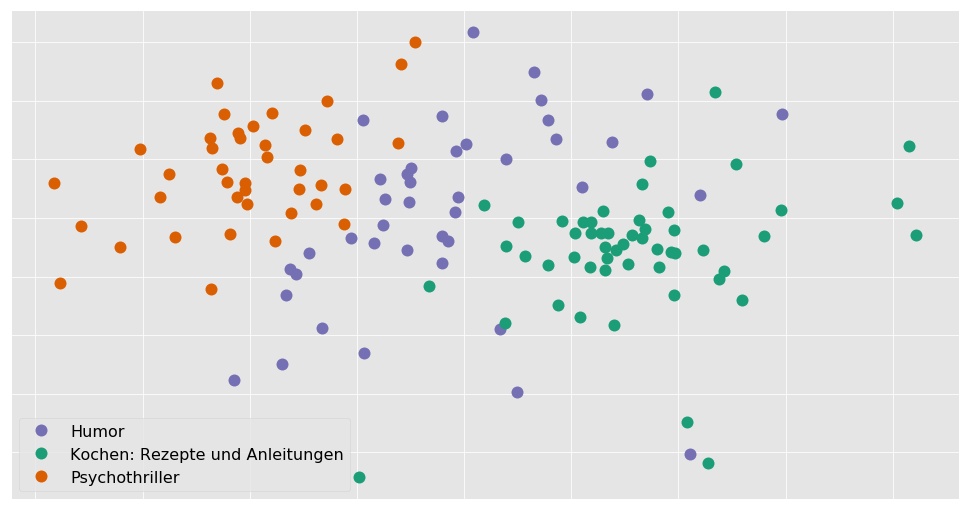

--------Plot generated using data from TSNE---------
name of theme = Humor, code = 2, color_key = #7570b3
name of theme = Kochen: Rezepte und Anleitungen, code = 0, color_key = #1b9e77
name of theme = Psychothriller, code = 1, color_key = #d95f02


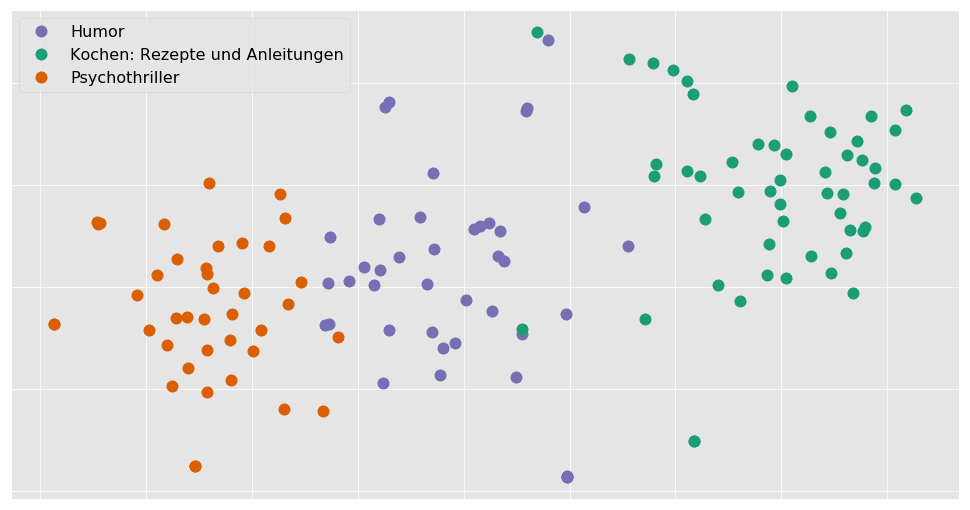

--------Plot generated using data from PCA---------
name of theme = Humor, code = 2, color_key = #7570b3
name of theme = Kochen: Rezepte und Anleitungen, code = 0, color_key = #1b9e77
name of theme = Psychothriller, code = 1, color_key = #d95f02


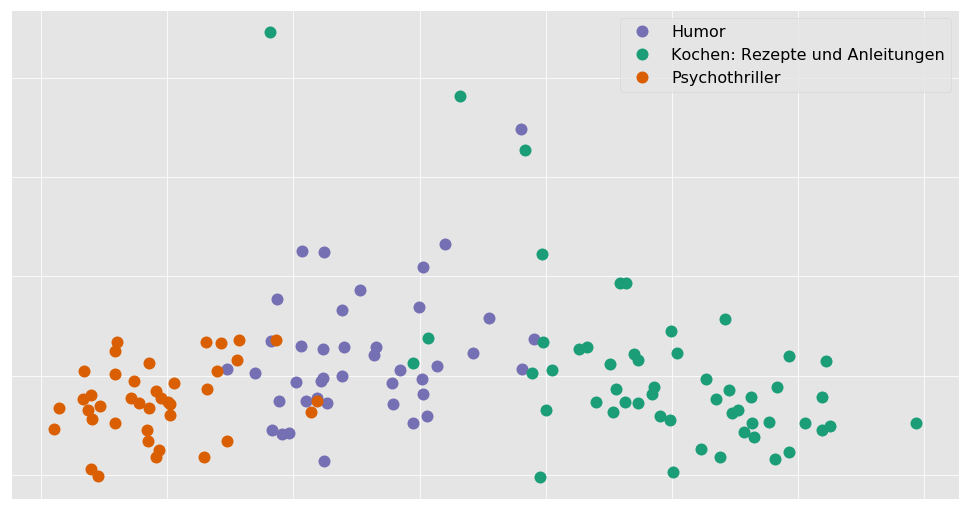

--------Plot generated using data from LLE---------
name of theme = Humor, code = 2, color_key = #7570b3
name of theme = Kochen: Rezepte und Anleitungen, code = 0, color_key = #1b9e77
name of theme = Psychothriller, code = 1, color_key = #d95f02


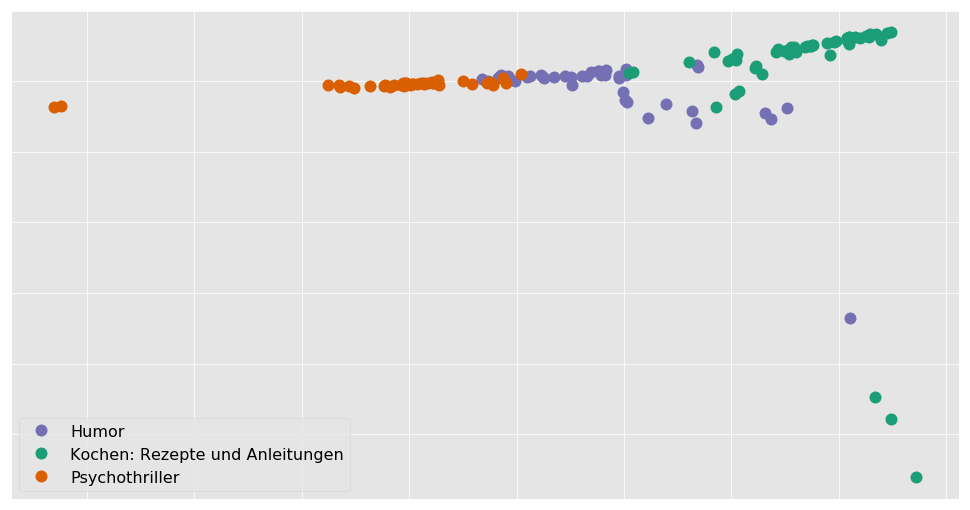

In [155]:
#create data frame that has the result of the MDS and other algorithms for the dimensionality reduction plus the cluster numbers and titles
df_mds = pd.DataFrame(dict(x=xs, y=ys, cluster_label=clusters_wmd, theme=train_theme, ID=train_id))
df_tsne = pd.DataFrame(dict(x=xs_tsne, y=ys_tsne, cluster_label=clusters_wmd, theme=train_theme, ID=train_id ))
df_pca = pd.DataFrame(dict(x=xs_pca, y=ys_pca, cluster_label=clusters_wmd, theme=train_theme, ID=train_id ))
df_lle = pd.DataFrame(dict(x=xs_lle, y=ys_lle, cluster_label=clusters_wmd, theme=train_theme, ID=train_id ))
df_iso = pd.DataFrame(dict(x=xs_iso, y=ys_iso, cluster_label=clusters_wmd, theme=train_theme, ID=train_id ))
df_nmds = pd.DataFrame(dict(x=xs_nmds, y=ys_nmds, cluster_label=clusters_wmd, theme=train_theme, ID=train_id ))
# define a list of data frames used for dimensionality reduction 
df_name_list = ["MDS","NMDS","TSNE","PCA","LLE","ISO"]
df_list = [df_mds, df_nmds, df_tsne, df_pca, df_lle, df_iso]
for i in range(0,5):
    print "--------Plot generated using data from %s---------" % df_name_list[i]
    plot_data(df_list[i], 'theme')

##### ============ GroundTruth data creation=======================
##### =============================================================
- Hypothesis: to prove the sanity of WMD, Harry potter query should match with all the harry potter books in the corpus 
and so would psychothriller with other psychothriller(s)

In [20]:
gt_train_text = []
# adding doc from existing corups, shows how WMD can  
# FINDING Duplicates + Central female character in retrieved documents
# Themes: Psychothriller, Humor, Kochen 134 docs corpus
for i in [0, 116, 89, 65, 53, 119, 112, 103, 83, 96]:
    gt_train_text.append(train_text[i])

# Adding Harry potter series book descriptions - 
gt_train_text.append("Harry Potter und der Stein der Weisen Als mysteriöse Briefe vor seiner Haustür ankommen, hat Harry Potter noch nie von der Hogwarts-Schule für Hexerei und Zauberei gehört. Sie werden schnell von seiner Tante und seinem Onkel konfisziert. Dann, an Harrys elften Geburtstag, kommt ein merkwürdiger Mann mit wichtigen Nachrichten herein: Harry Potter ist ein Zauberer und hat einen Platz bekommen, um in Hogwarts zu studieren. Und so soll das erste der Harry Potter-Abenteuer beginnen.")
gt_train_text.append("Harry Potter und die Kammer des Schreckens In den Sommerferien nach seinem ersten Jahr an der Hogwarts-Schule für Hexerei und Zauberei hat Harry Potter unheimliche Warnungen von einer Hauselfe namens Dobby erhalten. Jetzt, in der Schule, um sein zweites Jahr zu beginnen, hört Harry unverständliches Flüstern, das durch die Korridore hallt. In kurzer Zeit beginnen die Anschläge: Schüler werden gefunden, als wären sie zu Stein geworden. Dobbys Vorhersagen scheinen sich zu erfüllen.")
gt_train_text.append("Harry Potter und der Gefangene von Askaban Für Harry Potter ist es der Beginn eines weiteren ungewöhnlichen Jahres in Hogwarts, als der Knight Bus durch die Dunkelheit stürzt und vor ihm abrupt stehen bleibt. Es stellt sich heraus, dass Sirius Black, Massenmörder und Anhänger von Lord Voldemort, entkommen ist - und sie sagen, dass er nach Harry kommt. Professor Trelawney sieht in Harrys Teeblättern in seinem ersten Divinationsunterricht ein Todeszeichen. Und vielleicht am beängstigendsten sind die Dementoren, die auf dem Schulgelände mit ihrem Kuss auf der Seele patroullieren - auf der Suche nach neuen Opfern.")
gt_train_text.append("Harry Potter und der Feuerkelch Die Regeln des Trimagischen Turniers, das in Hogwarts stattfinden wird, erlauben nur Zauberern über siebzehn Jahren, einzutreten. Also kann Harry nur davon träumen, zu gewinnen. Dann, zu seiner Überraschung, am Halloween, wenn der Feuerkelch seine Auswahl trifft, wird sein Name aus dem magischen Kelch herausgesucht. Harry wird sich lebensgefährlichen Aufgaben stellen, Drachen und Dunklen Zauberern. Er wird sich auf die Hilfe seiner Freunde verlassen müssen, wenn er den Wettbewerb lebend durchstehen will.")
gt_train_text.append("Harry Potter und der Orden des Phönix Nach dem Angriff der Dementoren auf seinen Cousin Dudley weiß Harry, dass er bald Voldemorts nächstes Ziel werden wird. Obwohl viele die Rückkehr des Dunklen Lords bestreiten, ist Harry nicht allein und eine geheime Ordnung sammelt sich am Grimmauld Platz, um gegen die Dunklen Mächte zu kämpfen. Unterdessen werden Voldemorts wilde Angriffe auf Harrys Gedanken jeden Tag stärker. Er muss Professor Snape erlauben, ihm beizubringen, sich zu schützen, bevor ihm die Zeit davonläuft.")
gt_train_text.append("Harry Potter und der Halbblutprinz In einer Sommernacht, als Dumbledore im Ligusterweg ankommt, um Harry Potter einzusammeln, ist seine Zauberstabhand geschwärzt und schrumpelig, aber er wird nicht verraten, warum. Gerüchte und Misstrauen verbreiten sich in der Zaubererwelt - es fühlt sich an, als ob sogar Hogwarts selbst in Gefahr wäre. Harry ist überzeugt, dass Malfoy das Dunkle Mal trägt: Kann es einen Todesser unter ihnen geben? Er wird mächtige Magie und wahre Freunde brauchen, denn mit Hilfe von Dumbledore untersucht er Voldemorts dunkelste Geheimnisse.")
gt_train_text.append("Harry Potter und die Heiligtümer des Todes Harry Potter verlässt den Ligusterweg zum letzten Mal. Aber als er in den Beiwagen von Hagrids Motorrad steigt und in den Himmel steigt, weiß er, dass Lord Voldemort und die Todesser nicht weit dahinter sein werden. Der Schutzzauber, der ihn bis jetzt gerettet hat, ist gebrochen. Aber der Dunkle Lord atmet Angst in alles, was er liebt. Und er weiß, dass er sich nicht verstecken kann. Um Voldemort zu stoppen, weiß Harry, dass er die verbleibenden Horkruxe finden und zerstören muss. Er wird sich seinem Gegner in einem letzten Kampf stellen müssen.")
gt_train_text.append("Fantastische Bestien & wo sie zu finden sind Hogwarts Bibliothek Buch Ein anerkanntes Lehrbuch an der Hogwarts Schule für Hexerei und Zauberei seit der Veröffentlichung, Newt Scamanders Meisterwerk hat Zaubererfamilien über Generationen hinweg unterhalten. Phantastische Bestien und Orte, an denen sie zu finden sind, ist eine unverzichtbare Einführung in die magischen Bestien der Zaubererwelt. Scamanders Jahre des Reisens und der Forschung haben einen Band von beispielloser Bedeutung geschaffen. Einige der Tiere werden den Lesern der Harry-Potter-Bücher bekannt sein - der Hippogreif, der Basilisk, der Ungarische Hornschwanz ... Andere werden selbst den leidenschaftlichsten Amateurmagiziologen überraschen. Tauchen Sie ein, um die seltsamen Gewohnheiten von magischen Bestien auf fünf Kontinenten zu entdecken.")
gt_train_text.append("Quidditch im Wandel der Zeiten Ein ewiger Bestseller in der Zaubererwelt und eines der beliebtesten Bücher in der Hogwarts-Schulbibliothek. Quidditch Through the Ages enthält alles, was Sie jemals über die Geschichte, die Regeln - und das Brechen der Regeln - des edlen Sports wissen müssen von Quidditch. Vollgepackt mit faszinierenden Fakten, zeigt dieser maßgebliche Guide des angesehenen Quidditch-Autors Kennilworthy Whisp die Geschichte des Spiels von seinen frühen Ursprüngen im mittelalterlichen Nebel auf Queerditch Marsh bis hin zum modernen Sport, den so viele Zauberer- und Muggelfamilien auf der ganzen Welt lieben. Mit der umfassenden Berichterstattung über berühmte Quidditch-Teams, die häufigsten Fouls, die Entwicklung von Rennbesen")
# Addding LOTR whole series summary -
gt_train_text.append("Ein Ring, um sie alle zu beherrschen, Ein Ring, um sie zu finden, Ein Ring, um sie alle zu bringen und in der Dunkelheit zu binden In alten Zeiten wurden die Ringe der Macht von den Elfenschmieden hergestellt, und Sauron, der Dunkle Lord, schmiedete den Einen Ring und füllte ihn mit seiner eigenen Macht, so dass er alle anderen beherrschen konnte. Aber der Eine Ring wurde von ihm genommen, und obwohl er es überall in Mittelerde suchte, blieb es für ihn verloren. Nach vielen Jahrhunderten fiel es zufällig in die Hände des Hobbit Bilbo Beutlin. Von Saurons Echtheit im Dunklen Turm von Mordor aus verbreitete sich seine Macht weit und breit. Sauron sammelte alle Großen Ringe für ihn, aber immer suchte er nach dem Einen Ring, der seine Herrschaft vervollständigen würde. Als Bilbo seinen einundsiebzigsten Geburtstag erreichte, verschwand er und hinterließ seinem jungen Cousin Frodo den Herrschenden Ring und eine gefährliche Aufgabe: über Mittelerde, tief in den Schatten des Dunklen Lords zu reisen und den Ring zu zerstören, indem er ihn in die Wüste warf Risse des Schicksals. Der Herr der Ringe erzählt von der großen Suche von Frodo und der Gemeinschaft des Ringes: Gandalf der Zauberer; die Hobbits Merry, Pippin und Sam; Gimli der Zwerg; Legolas der Elf; Boromir von Gondor; und ein großer, geheimnisvoller Fremder namens Strider.")

# Adding Sherlock Holmes book descriptions -
gt_train_text.append("Die Sherlock Holmes Serie von Arthur Conan Doyle Seit Doyle den unsterblichen Sherlock Holmes und seinen Assistenten Dr. Watson geschaffen hat, ist ihm kein anderer Mystery-Autor nahe gekommen, ihn als Standardträger in der Kriminalliteratur zu übertrumpfen. Ein brillanter Londoner beratender Detektiv, Holmes ist berühmt für seine intellektuelle Tapferkeit und bekannt für seinen geschickten Einsatz von kluger Beobachtung, deduktivem Denken und Schlussfolgerung, um schwierige Fälle zu lösen. Sherlock Holmes ist der einzige beratende Detektiv der Welt. Geld und Prestige interessieren ihn nicht, einfach die Möglichkeit, seine intellektuellen Muskeln zu trainieren und seine einzigartige Methode der Deduktion zu üben. Indem Sie ihm durch eine Reihe von Problemen folgen, können Sie einen großartigen Geist bei der Arbeit beobachten und in die kriminelle Welt von London eintauchen.")
gt_train_text.append("Ein Skandal in Böhmen Juli 1891 Der König von Böhmen bittet Holmes um ein indiskretes Foto, das ihn mit der berühmten Schönheits-, Abenteuers- und Opernsängerin Irene Adler zeigt, deren Offenbarung seine Ehe mit einer Tochter des Königs von Skandinavien entgleisen würde. In der Verkleidung stellt Holmes fest, dass Adler den Mann heiratet, den sie wirklich liebt, und entdeckt dann durch eine ausgeklügelte List das Versteck der Fotografie. Aber als Holmes und der König zurückkommen, um das Foto zu holen, finden sie heraus, dass Adler damit geflohen ist und einen Brief für Holmes und ein Porträt von sich selbst für den König hinterlassen hat. Der König erlaubt Holmes, das Porträt als Andenken zu behalten. ")
gt_train_text.append("The Red-Headed League August 1891 Jabez Wilson, ein Pfandleiher, berät Holmes über einen Job, den er nur wegen seiner roten Haare gewonnen hat. Der Job brachte ihn jeden Nachmittag für kurze Zeit aus seinem Laden und verwickelte ihn in die Encyclopædia Britannica. Nach acht Wochen wurde ihm mitgeteilt, dass der Job plötzlich beendet sei. Holmes besucht das Pfandleihergeschäft und nach einigen Ermittlungen kontaktiert er einen Polizeiinspektor und den Manager einer Bank in der Nähe. Zusammen mit Watson verstecken sie sich im Banktresor und fangen zwei Diebe, die in den Stunden, in denen Wilson jeden Nachmittag draußen war, einen Tunnel aus dem Laden gegraben hatten.")
gt_train_text.append("Ein Fall von Identität September 1891 Gegen den Willen ihres Stiefvaters hat sich Fräulein Mary Sutherland mit Hosmer Angel verlobt. Am Morgen ihrer Hochzeit löst Hosmer das Versprechen aus, dass Maria ihm treu bleiben werde, auch wenn etwas ganz Unvorhergesehenes passiert und dann auf geheimnisvolle Weise auf dem Weg zur Kirche verschwindet. Holmes folgert, dass Hosmer der verkleidete Stiefvater Marias war. Die Scharade versuchte, seine Stieftochter zur Jungfernschaft zu verurteilen und seinen weiteren Zugang zu ihrem Erbe sicherzustellen. Holmes offenbart Maria nicht die Wahrheit, denn Es besteht Gefahr für ihn, der das Tigerjunge nimmt, und Gefahr auch für denjenigen, der einer Frau eine Täuschung entreißt; er hatte ihr bereits geraten, die Sache hinter sich zu lassen, obwohl sie antwortete, dass Hosmer mich finden werde, wenn er zurückkommt.")
gt_train_text.append("Boscombe Valley Mystery Oktober 1891 Inspektor Lestrade bittet Holmes um Hilfe, nachdem Charles McCarthy ermordet wurde, und sein Sohn James ist verwickelt. McCarthy und ein anderer lokaler Grundbesitzer, John Turner, sind beide australische Expatriates, und Lestrade wurde ursprünglich von Turners Tochter Alice engagiert, die James für unschuldig hält. Holmes interviewt James und inspiziert dann den Tatort, aus dem hervorgeht, dass ein dritter Mann anwesend war. Als er erkennt, dass Holmes den Fall gelöst hat, bekennt sich Turner zu dem Verbrechen und offenbart, dass McCarthy ihn wegen Turners krimineller Vergangenheit erpresst hat. Holmes enthüllt das Verbrechen nicht, sichert aber James Freilassung wegen der Anwesenheit einer dritten Person am Tatort.")
gt_train_text.append("Die fünf Orangen Pips November 1891 John Openshaw erzählt Holmes von zwei seltsamen Todesfällen in seiner Familie. Im Jahr 1883 starb sein Onkel zwei Monate nach Erhalt eines Briefes aus Indien, bezeichnet K.K.K. mit fünf orangefarbenen Pips. 1885 erhielt Openshaws Vater einen ähnlichen Brief und starb drei Tage danach. Openshaw erhielt kürzlich einen ähnlichen Brief und bittet um Rat. Holmes teilt Openshaw mit, wie der Brief fragt und hinterlässt eine Tagebuchseite, die, wie Holmes schließt, mit dem Ku-Klux-Klan auf der Gartensonnenuhr verbunden ist. Openshaw wird getötet, bevor er das tun kann, aber Holmes entdeckt, dass die Killer auf einem Segelschiff unterwegs waren, und schickt dem Captain einen Brief mit fünf orangefarbenen Pips. Das Schiff ist auf See verloren.")

#tokenize and #remove stop words
%time gt_texts = [tokenize_and_stopWordsRemoval(text.decode('utf-8')) for text in gt_train_text]
len(gt_texts)
print " ".join(gt_texts[21])

CPU times: user 74.8 ms, sys: 4.34 ms, total: 79.1 ms
Wall time: 76.5 ms
Skandal Böhmen Juli König Böhmen bittet Holmes indiskretes Foto berühmten Schönheits- Abenteuers- Opernsängerin Irene Adler zeigt deren Offenbarung Ehe Tochter Königs Skandinavien entgleisen Verkleidung stellt Holmes fest Adler Mann heiratet wirklich liebt entdeckt ausgeklügelte List Versteck Fotografie Holmes König zurückkommen Foto holen finden heraus Adler geflohen Brief Holmes Porträt König hinterlassen König erlaubt Holmes Porträt Andenken behalten


In [35]:
# assigning theme tags for ground truth data
gt_themes = []
for i in range(0, 26):
    if(i<= 9):
        gt_themes.append("Psychothriller") 
    if(i>9 and i <= 20):
        gt_themes.append("HarryPotter") 
    if(i > 20):
        gt_themes.append("SherlockHolmes") 
# assigining ID tags for ground truth data
gt_id = []
for i in range(0, 26):
    gt_id.append(i)

# converting the text data into lower case to be used effectively by model01 since vocabulary here is lowercase.
gt_textsLower = [[j.lower() for j in i] for i in gt_texts]

In [34]:
# def kNearestNeighborWMD(textCorpusOriginal, textCorpusProcessed, embeddingModel, query, k):
kNearestNeighborWMD(gt_train_text, gt_texts, model02, gt_texts[11], 10)

Cell took 0.86 seconds to run.
Query:
Harry Potter Kammer Schreckens Sommerferien ersten Jahr Hogwarts-Schule Hexerei Zauberei Harry Potter unheimliche Warnungen Hauselfe namens Dobby erhalten Schule zweites Jahr beginnen hört Harry unverständliches Flüstern Korridore hallt kurzer Zeit beginnen Anschläge Schüler gefunden wären Stein geworden Dobbys Vorhersagen scheinen erfüllen

sim = 1.0000
11
Harry Potter und die Kammer des Schreckens In den Sommerferien nach seinem ersten Jahr an der Hogwarts-Schule für Hexerei und Zauberei hat Harry Potter unheimliche Warnungen von einer Hauselfe namens Dobby erhalten. Jetzt, in der Schule, um sein zweites Jahr zu beginnen, hört Harry unverständliches Flüstern, das durch die Korridore hallt. In kurzer Zeit beginnen die Anschläge: Schüler werden gefunden, als wären sie zu Stein geworden. Dobbys Vorhersagen scheinen sich zu erfüllen.

sim = 0.7145
10
Harry Potter und der Stein der Weisen Als mysteriöse Briefe vor seiner Haustür ankommen, hat Harry Po